<a href="https://colab.research.google.com/github/Aduomas/PP9/blob/main/Practise_Task_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

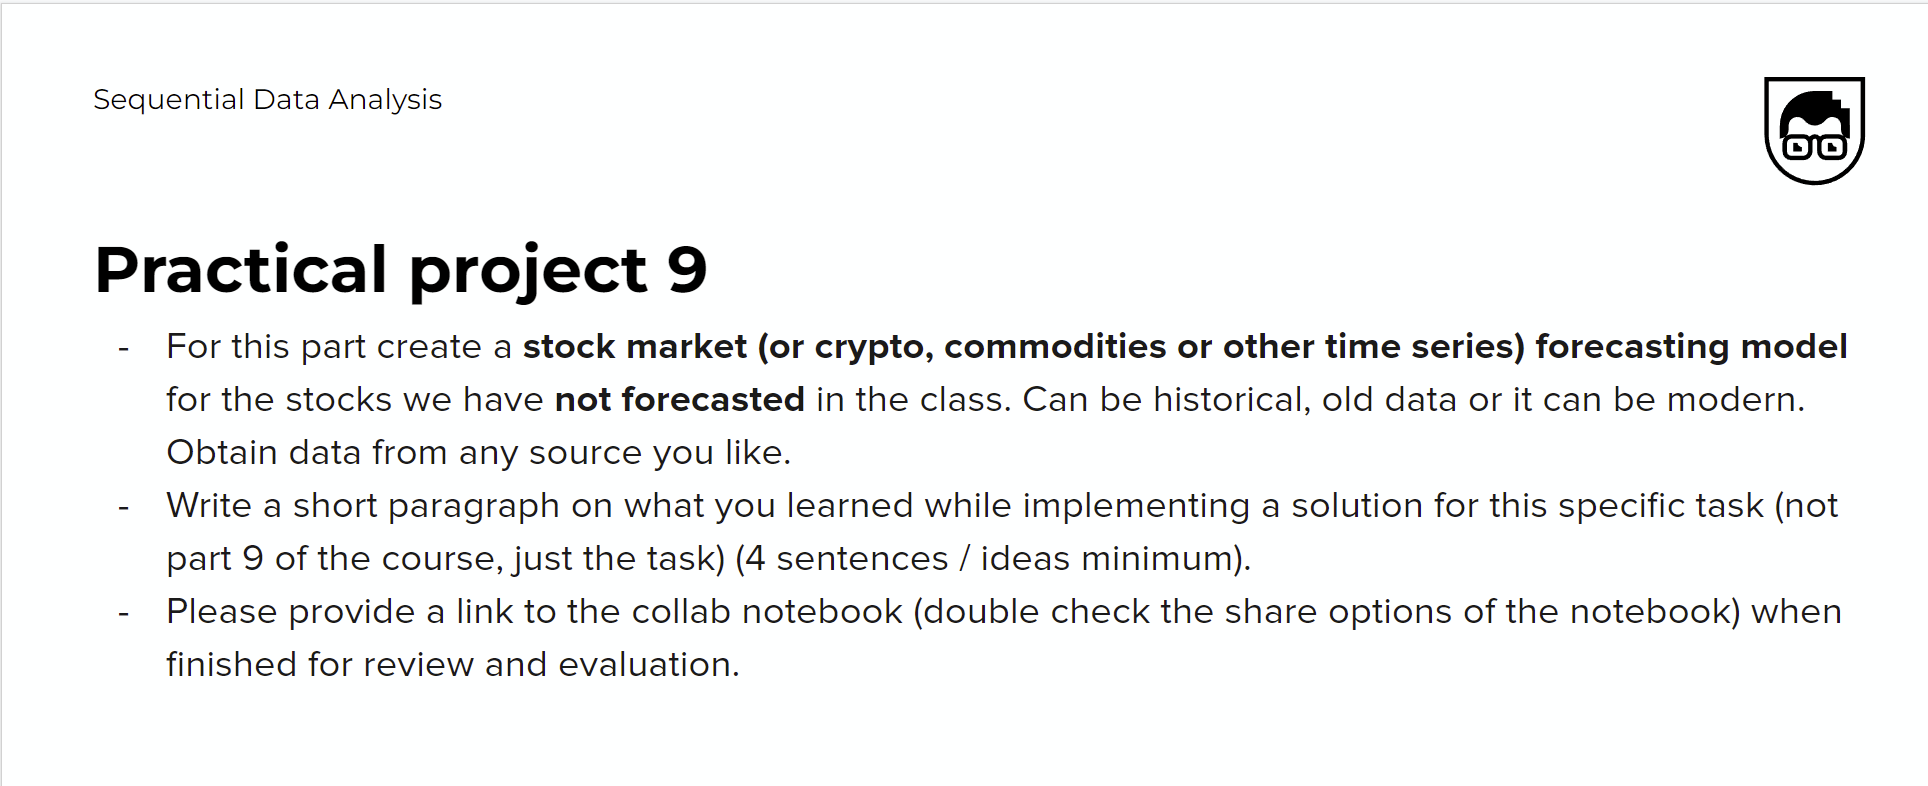

# Choosing a dataset - NVIDIA stock

In [ ]:
import pandas_datareader.data as web
import pandas as pd

df = web.DataReader('NVDA', 'stooq')
df = df.reindex(index=df.index[::-1])
df

,Open,High,Low,Close,Volume
Date,,,,,
2017-01-17,25.415,25.465,24.8210,24.955,55499292
2017-01-18,24.736,25.472,24.4580,25.402,54975619
2017-01-19,25.432,26.271,25.4100,25.951,62995722
2017-01-20,26.177,26.357,25.4450,25.667,48605620
2017-01-23,25.614,26.131,25.5890,25.934,36374882
...,...,...,...,...,...
2022-01-10,265.810,274.690,256.4384,274.000,59468095
2022-01-11,273.225,280.650,268.3900,278.170,40408929
2022-01-12,280.665,285.950,276.0800,279.990,38341348


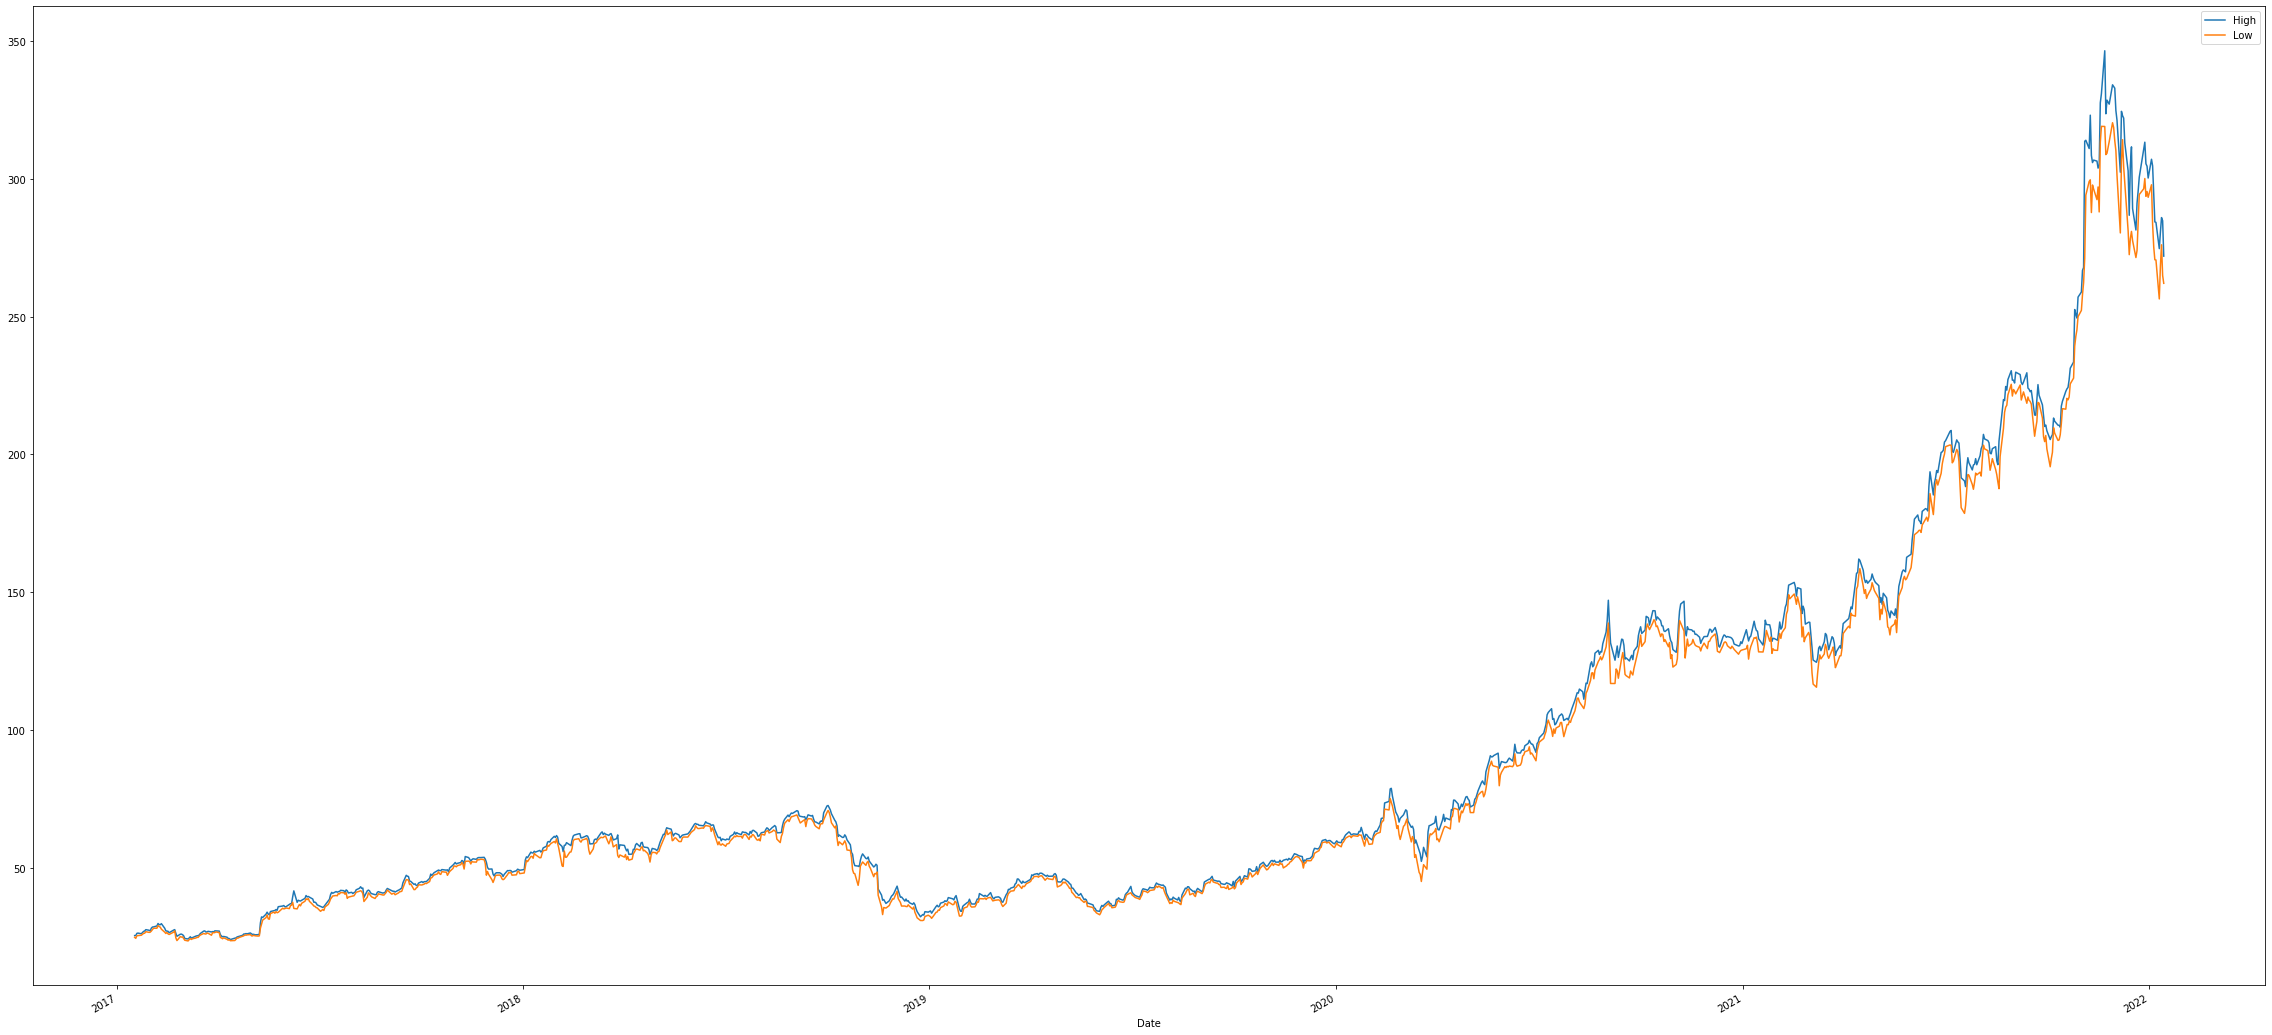

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (40,20)

df.drop(['Volume', 'Open', 'Close'], axis=1).plot()

### Preprocess data

In [ ]:
new_dataset = df.copy()['Close'].to_frame()
new_dataset

,Close
Date,
2017-01-17,24.955
2017-01-18,25.402
2017-01-19,25.951
2017-01-20,25.667
2017-01-23,25.934
...,...
2022-01-10,274.000
2022-01-11,278.170
2022-01-12,279.990


### Split into train, test data, split into sequences

In [ ]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, GRU
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(new_dataset)

train_data = new_dataset[0:1008]
test_data = new_dataset[1008:]

# construct the sequences: we will try to predict y
# ... based on last 14 values of x
x_train_data,y_train_data=[],[]
for i in range(30, len(train_data)):
    x_train_data.append(scaled_data[i-30:i,0])
    y_train_data.append(scaled_data[i,0])

# convert to numpy
x_train_data, y_train_data = np.array(x_train_data), np.array(y_train_data)
x_train_data= np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

x_test_data,y_test_data=[],[]
for i in range(len(train_data), len(scaled_data)):
    x_test_data.append(scaled_data[i-30:i,0])
    y_test_data.append(scaled_data[i,0])

# convert to numpy
x_test_data, y_test_data = np.array(x_test_data), np.array(y_test_data)
x_test_data= np.reshape(x_test_data,(x_test_data.shape[0],x_test_data.shape[1],1))

### Initilialize the model using GRU gates

In [ ]:
gru_model=Sequential()
gru_model.add(GRU(units=1000, return_sequences=True, input_shape=(x_train_data.shape[1], 1)))
gru_model.add(GRU(units=1000))
gru_model.add(Dense(1))

gru_model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003))
history = gru_model.fit(x_train_data,y_train_data, epochs=10, batch_size=16, verbose=1, validation_data=(x_test_data, y_test_data))

Epoch 1/10
62/62 [==============================] - 11s 105ms/step - loss: 0.0010 - val_loss: 6.5187e-04
Epoch 2/10
62/62 [==============================] - 6s 92ms/step - loss: 7.5617e-05 - val_loss: 6.4487e-04
Epoch 3/10
62/62 [==============================] - 6s 92ms/step - loss: 7.2233e-05 - val_loss: 6.0418e-04
Epoch 4/10
62/62 [==============================] - 6s 92ms/step - loss: 6.6069e-05 - val_loss: 6.1677e-04
Epoch 5/10
62/62 [==============================] - 6s 92ms/step - loss: 6.8196e-05 - val_loss: 0.0011
Epoch 6/10
62/62 [==============================] - 6s 92ms/step - loss: 6.8113e-05 - val_loss: 5.4707e-04
Epoch 7/10
62/62 [==============================] - 6s 91ms/step - loss: 6.9921e-05 - val_loss: 6.7456e-04
Epoch 8/10
62/62 [==============================] - 6s 92ms/step - loss: 6.0134e-05 - val_loss: 5.7105e-04
Epoch 9/10
62/62 [==============================] - 6s 91ms/step - loss: 5.9976e-05 - val_loss: 6.6935e-04
Epoch 10/10
62/62 [========================

### Plot train, val loss vs epoch

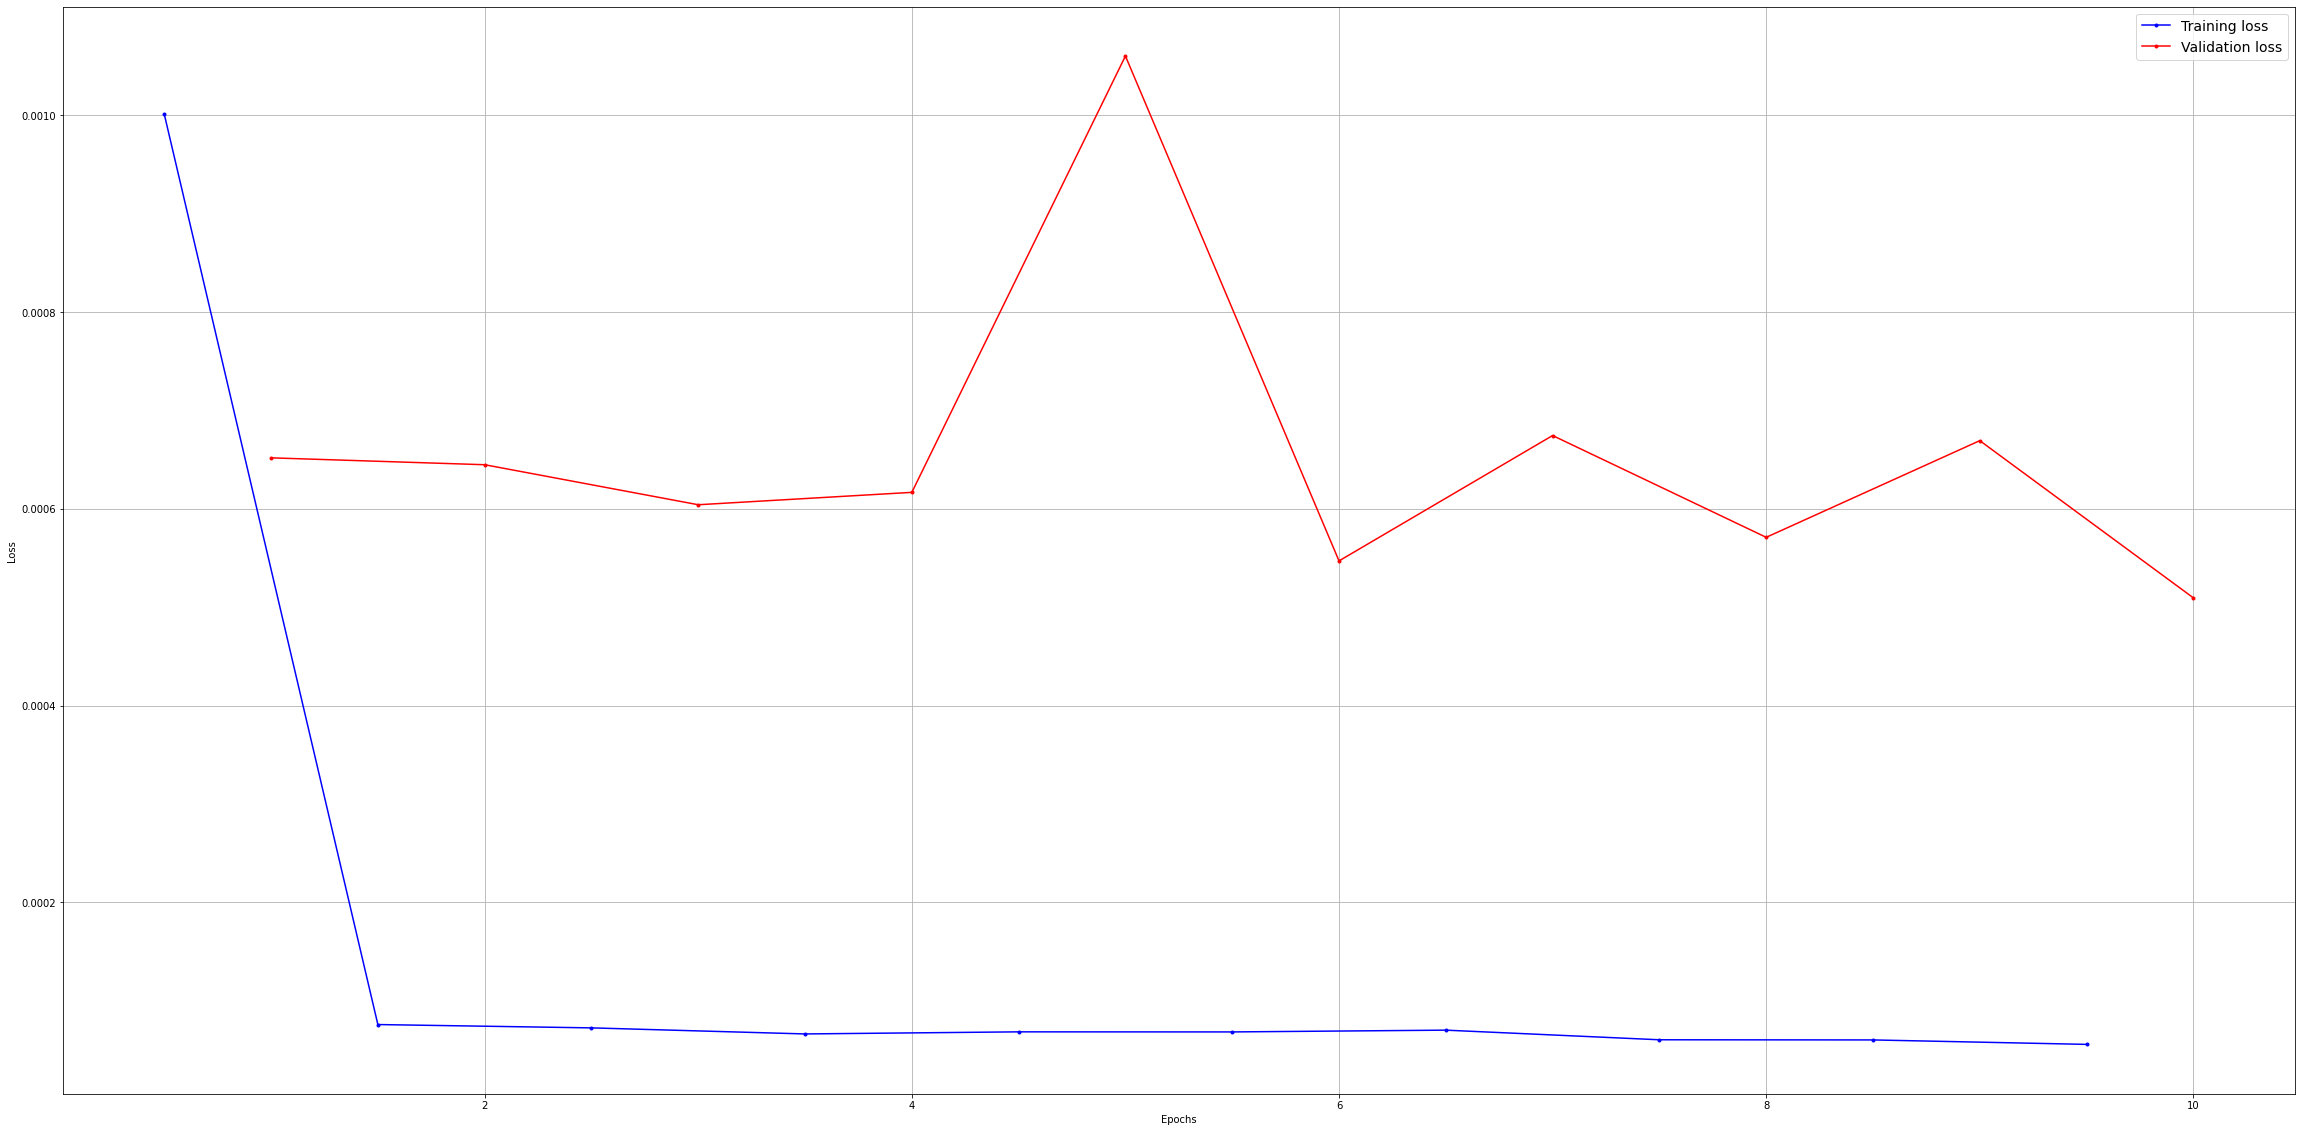

In [ ]:
import matplotlib as mpl
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### Predict

In [ ]:
predicted_closing_price=gru_model.predict(x_test_data)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

### Plot predictions vs actual

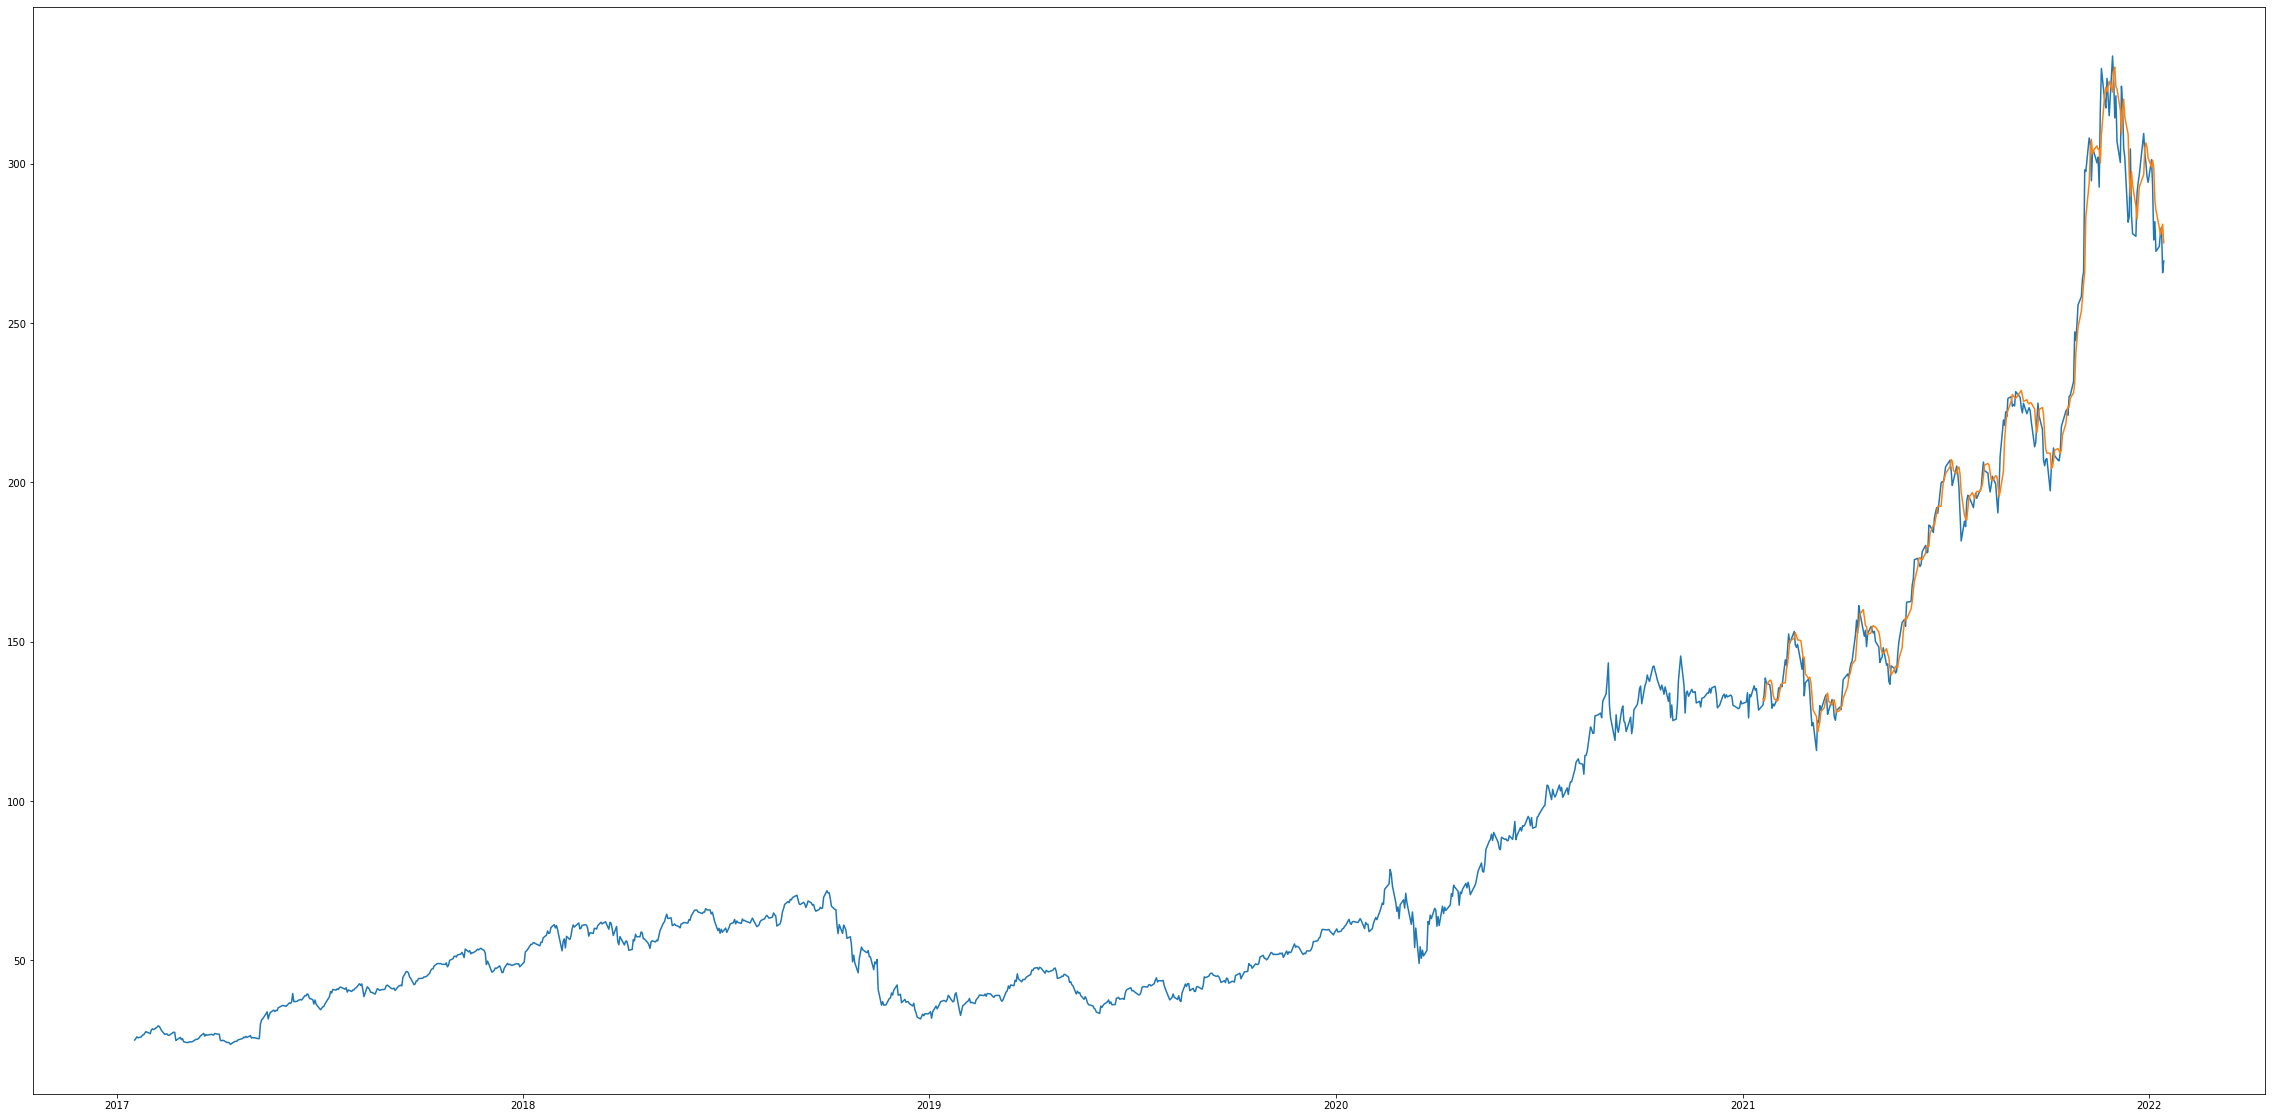

In [ ]:
plt.plot(new_dataset['Close'])
plt.plot(test_data.index, predicted_closing_price)

### MSE

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test_data['Close'],predicted_closing_price)

# 49.01576961193412 is the only time i got it below 50 (from ~30 different parameter runs)
# GRU 1000, GRU 1000, epoch 10, batch_size 16, learning_rate = 0.0003

49.01576961193412

In [ ]:
test_data = test_data.assign(Predictions=predicted_closing_price)
test_data.tail(14)

,Close,Predictions
Date,,
2021-12-28,303.22,304.795013
2021-12-29,300.01,306.517242
2021-12-30,295.86,304.955566
2021-12-31,294.11,301.678223
2022-01-03,301.21,298.916290
2022-01-04,292.90,301.058624
2022-01-05,276.04,298.749207
2022-01-06,281.78,288.716156
2022-01-07,272.47,285.352844


### Conclusion

- I've learnt how to get desired stock prices using pandas data-reader. I've decided to use NVIDIA stock, because market volume is high and it is quite volatile.

- I've found that there is slight difference between LSTM and GRU and usually GRU managed to have better results than LSTM.

- I've found that Low batch size and very low learning rate seems to be useful working RNN models.

- I've found that 60 day sequences or 30 day sequences doesn't make large difference in accuracy, although it seems to be slightly faster with 30 day sequences. Although 14 day sequences makes model hard to guess correctly.